In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import creme
import utils
import shutil
import pickle
import glob
import pandas as pd
import numpy as np
import itertools, os
from tqdm import tqdm

In [3]:
cell_lines = [4824, 5110, 5111]
cell_line_names = ['PC-3', 'GM12878', 'K562']
bin_index = [447, 448]
model_name = 'enformer'
pdf_dir = utils.make_dir('pdf_dir')

threshold_enh, threshold_neu, threshold_sil = 0.95, 0.05, -0.3

In [39]:
res = []
for i, c in enumerate(cell_lines):
    selected_tss_path = glob.glob(f'../results/gencode_tss_predictions/{model_name}/*{c}*_selected_tss.csv')[0]
    cell_name = selected_tss_path.split('_')[-3]
    delta_means = []
    wt_means = []
    delta_stds = []
    paths = []
    print(cell_name)
    selected_tss = pd.read_csv(selected_tss_path)
    for _, row in selected_tss.iterrows():
        
        r = f'../results/context_dependence_test/{model_name}/{utils.get_summary(row)}.pickle'
        with open(r, 'rb') as handle:
            context_res = pickle.load(handle)
        delta = creme.context_effect_on_tss(context_res['wt'][bin_index,i].mean(), context_res['mut'][bin_index,i].mean())
        delta_means.append(delta)
        # delta_stds.append(delta.std())
        wt_means.append(context_res['wt'][bin_index,i].mean())
        paths.append(r)
        
    df = pd.DataFrame([delta_means, paths]).T
    df.columns = ['delta mean', 'path']
    df['wt'] = wt_means
    # df = df[df['delta std'] < np.quantile(df['delta std'], 0.99)]
    df['context'] = [v for v in pd.cut(df['delta mean'], 
                                       [df['delta mean'].min()-1, threshold_sil, -threshold_neu, threshold_neu, threshold_enh, df['delta mean'].max()+1], 
                           labels=['silencing', 'other1', 'neutral', 'other', 'enhancing']).values]
    df['cell line'] = cell_name
    
    print(df.shape)
    res.append(df)

res = pd.concat(res)
    

PC-3
(10000, 5)
GM12878
(10000, 5)
K562
(10000, 5)


In [40]:
res.to_csv(f'../results/context_dependence_test/{model_name}_result_summary.csv')

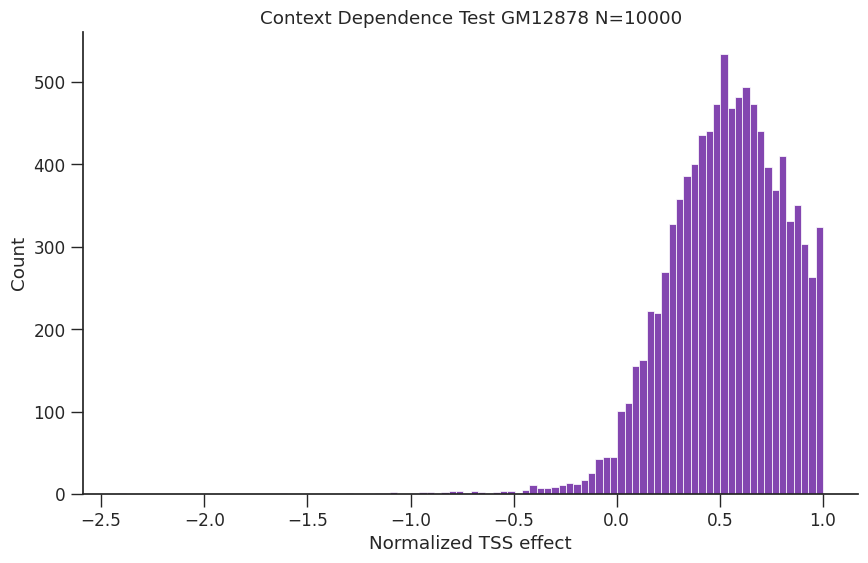

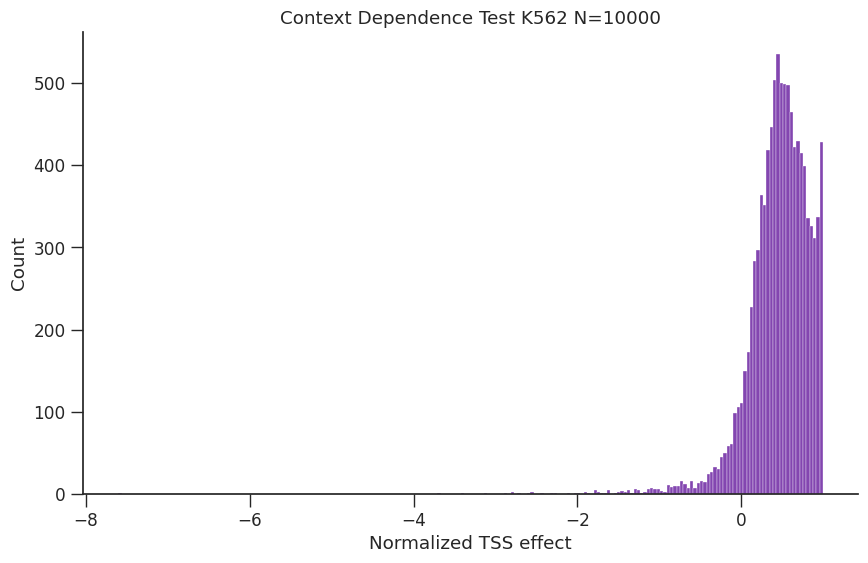

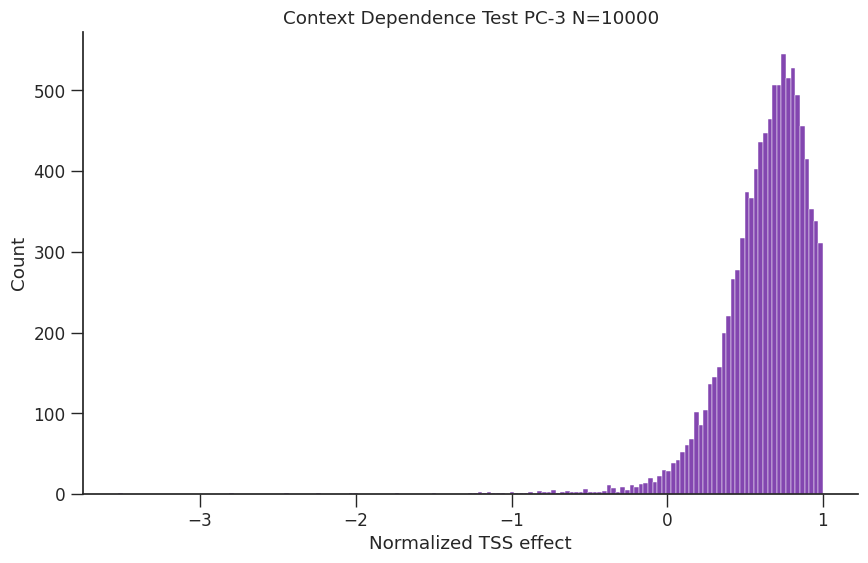

In [31]:
sns.set(font_scale = 1.1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in res.groupby('cell line'):
    
    fig = plt.figure(figsize=[10, 6])
    ax = sns.histplot(x=df['delta mean'], color='#5A0896')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlabel('Normalized TSS effect') # (WT - M) / WT
    plt.title(f'Context Dependence Test {k} N={df.shape[0]}')
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


(423, 5)
(191, 5)
(78, 5)
['enhancing (N=200)', 'neutral (N=191)', 'silencing (N=78)']
(507, 5)
(285, 5)
(323, 5)
['enhancing (N=200)', 'neutral (N=200)', 'silencing (N=200)']
(539, 5)
(105, 5)
(93, 5)
['enhancing (N=200)', 'neutral (N=105)', 'silencing (N=93)']


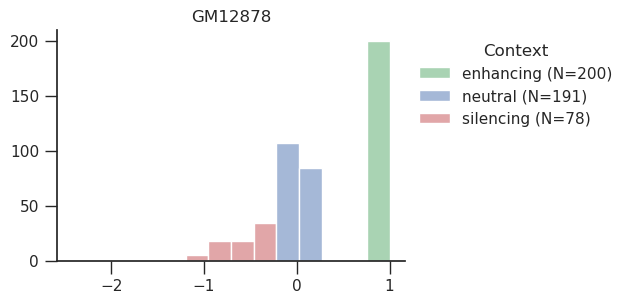

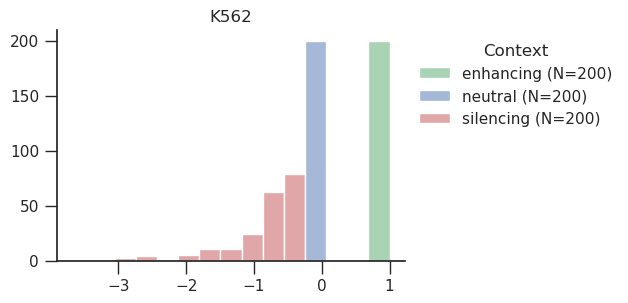

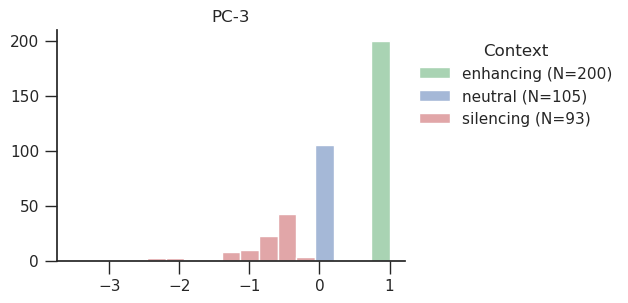

In [32]:
max_sample_size = 200
for k, df in res.groupby('cell line'):
    
    
    fig = plt.figure(figsize=[4.5, 3])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    context_df = df[(df['context']!='other') & (df['context']!='other1')]
    context_df_subsample = []
    for context_type, one_context_df in context_df.groupby('context'):
        print(one_context_df.shape)
        if one_context_df.shape[0] > max_sample_size:
            
            context_df_subsample.append(one_context_df.sample(max_sample_size, random_state=42))
        else:
            context_df_subsample.append(one_context_df)
    context_df = pd.concat(context_df_subsample)

    context_df = context_df.sort_values('context')
    ax = sns.histplot(data=context_df, 
                      x='delta mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)
    # plt.ylim(0,100)
    # plt.xlim([-2,1.1])
    # plt.yticks([0,50,100])
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')
    context_df.to_csv(f'../results/context_dependence_test/{model_name}/{k}_context.csv')


In [35]:
df

,delta mean,path,wt,context,cell line
0,0.510139,../results/context_dependence_test/enformer/XP...,14.783686,other,PC-3
1,0.939964,../results/context_dependence_test/enformer/UP...,14.785568,other,PC-3
2,0.874547,../results/context_dependence_test/enformer/PL...,14.797552,other,PC-3
3,-0.996532,../results/context_dependence_test/enformer/ZN...,14.800878,silencing,PC-3
4,0.847226,../results/context_dependence_test/enformer/SL...,14.805020,other,PC-3
...,...,...,...,...,...
9995,0.672157,../results/context_dependence_test/enformer/CC...,447.296265,other,PC-3
9996,0.704326,../results/context_dependence_test/enformer/MD...,449.297974,other,PC-3
9997,0.576422,../results/context_dependence_test/enformer/HS...,451.603577,other,PC-3
9998,0.553474,../results/context_dependence_test/enformer/IT...,454.687561,other,PC-3


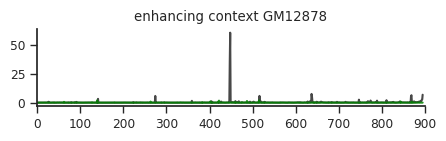

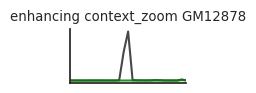

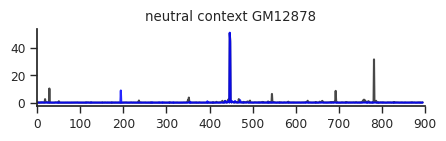

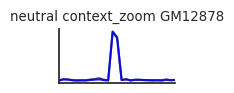

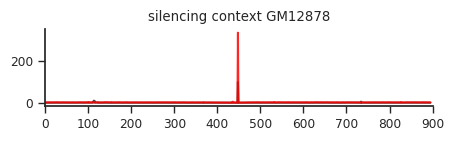

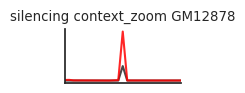

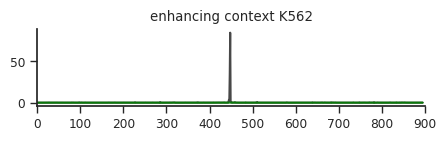

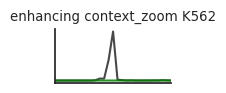

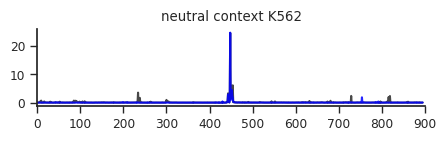

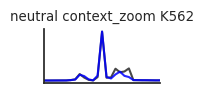

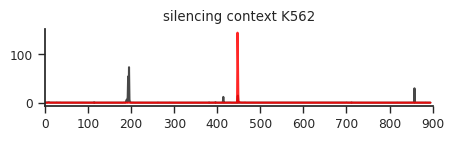

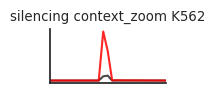

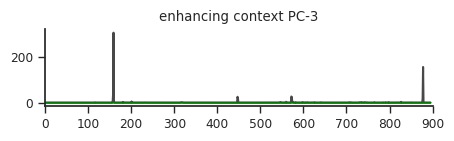

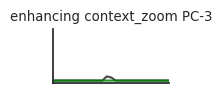

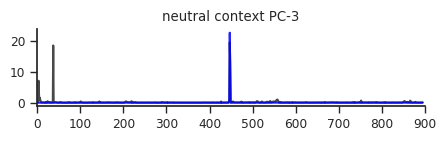

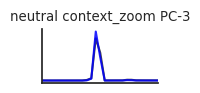

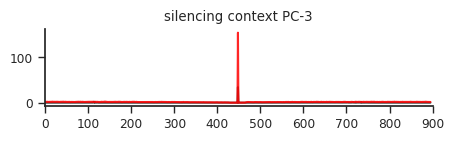

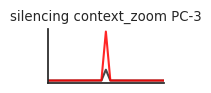

In [33]:
for k, df in res.groupby('cell line'):
    
    cell_pred_index = cell_line_names.index(k)

    # select most illustrative cases
    
    for name, color, selected_point in zip(['enhancing context', 'neutral context', 'silencing context'],
                                    ['green', 'blue', 'red'],
                                    [df[df['context']=='enhancing'].sort_values('delta mean')['path'].values[-1],
                                     df[df['context']=='neutral']['path'].values[0],
                                     df[df['context']=='silencing'].sort_values('delta mean')['path'].values[0]
                                     ]):
        with open(selected_point, 'rb') as handle:
            context_res = pickle.load(handle)
        wt = context_res['wt'][:, cell_pred_index]
        mut = context_res['mut'][:, cell_pred_index]
        for zoom in [None, [425, 475]]:
            if zoom:
                fig = plt.figure(figsize=[1.5, .7])
                name = name + '_zoom'
            else:
                fig = plt.figure(figsize=[5, 1])
                
            sns.set(font_scale = .8)
        
            sns.set_style(style='white')
            plt.rcParams['xtick.major.size'] = 5
            plt.rcParams['xtick.major.width'] = 1
        
            plt.rcParams['ytick.major.size'] = 5
            plt.rcParams['ytick.major.width'] = 1
            plt.rcParams['xtick.bottom'] = True
            plt.rcParams['ytick.left'] = True
        
            plt.plot(wt, 'k', alpha=0.8)
            plt.plot(mut, color=color, alpha=0.85)
            plt.xlim(0, 900)
            
            if zoom is None:
                if k == 'strong':
                    plt.ylabel('TSS activity')
                if k == 'repressing CRE':
                    plt.xlabel('Binned positions (128 nt)')
                    
            if zoom:
                sns.set(font_scale = .8)
                plt.xticks([])
                plt.yticks([])
                plt.xlim(435, 461)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.title(f'{name} {k}')
            plt.show()
            # fig.savefig(f'{pdf_dir}/{model_name}_{k}_{name}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    #     break
    # break

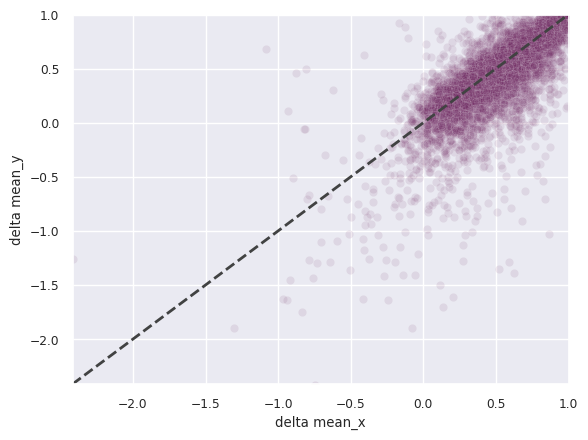

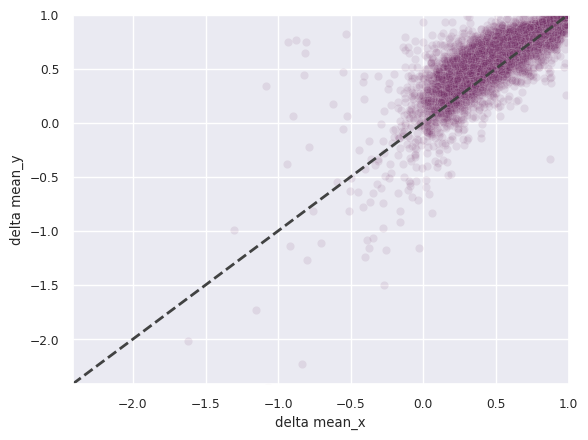

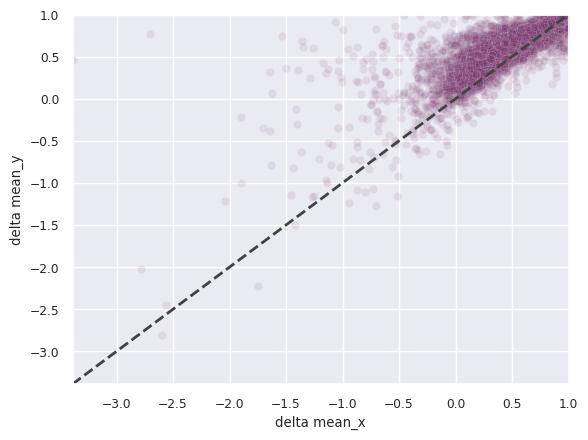

In [38]:
for df1, df2 in list(itertools.combinations([df for _, df  in res.groupby('cell line')], 2)):
    diff_comp = df1.merge(df2, on='path')
    sns.scatterplot(data=diff_comp, x='delta mean_x', y='delta mean_y', edgecolors=None, color='#702963', alpha=0.1)
    min_point = np.array(diff_comp['delta mean_x'], diff_comp['delta mean_y']).min()
    # add y=x line
    plt.plot([min_point,1],[min_point,1], lw=2, color='#414242', linestyle='dashed')
    # plt.xlabel(f'{c1} normalized TSS effect')
    # plt.ylabel(f'{c2} normalized TSS effect')
    plt.xlim(min_point,1)
    plt.ylim(min_point,1)
    plt.show()